# Homework 2
Marco Boscato - 2096921

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Exercise 1
First, let's write a 4th order Runge-Kutta integrator to solve later ODEs of this type:

$$
\frac{dx}{dt} = f(t,x) \quad\quad\quad\quad x(t_{0}) = x_{0}
$$

In [2]:
def RK_4th_order(f, x0, t0, tf, h):
    t = np.arange(t0, tf, h)
    n = len(t)
    x = np.zeros([n, len(x0)], dtype=float)
    x[0] = x0

    for i in range(n-1):
        k1 = h*f(t[i], x[i])
        k2 = h*f(t[i] + h/2, x[i] + k1/2)
        k3 = h*f(t[i] + h/2, x[i] + k2/2)
        k4 = h*f(t[i] + h, x[i] + k3)

        x[i+1] = x[i] + (k1 + 2*k2 + 2*k3 + k4)/6.0

    return t, x

### Exercise 2
Now we proceed by solving a 2-body problem, first with the integrator written earlier and then with an integrator provided by `scipy`.

In [3]:
# initial conditions
GM = 398600.4415 # km^3/s^2   (gravitational parameter of the Earth)
position = np.array([[0., 0.], [384400.0, 0.]])                         #position of the two bodies (x,y) in klometers
velocity = np.array([[0., 0.], [0.91647306922544, 0.91647306922544]])   #velocity of the two bodies (vx,vy) in km/s
particles = np.concatenate((position, velocity), axis=None)             #concatenate position and velocity of the two bodies as x(t) 
                                                                        #for RK_4th_order
                                                  
# time interval
t0 = 0
tf = 3e6
h = 1e2

# equations of the acceleration of two bodies:
def acceleration_two_body(t, x):
    r12 = x[2:4] - x[0:2]
    denom = np.linalg.norm(r12)**3
    acc = GM*(x[2:4] - x[0:2]) / denom
    return np.array(np.concatenate((x[4:6], x[6:8], acc, -acc), axis=0))    # return the acceleration of the two bodies in 1D 
                                                                            #for RK_4th_order

# R-K of 4th order
time1, orbit1 = RK_4th_order(acceleration_two_body, particles, t0, tf, h)

# calculate the position of the Center of Mass
cm1 = np.empty([len(orbit1), 2], dtype=float)
for i in range(len(orbit1)):
    cm1[i] = np.sum(orbit1[i].reshape(-1, 2), axis=0)/2.0

we can also calculate the relative energy of the integrator

In [4]:
def Energy(x):
    r12 = x[:,2:4] - x[:,0:2]
    E = 0.5*np.sum(x[:,4:6]**2, axis=1) + 0.5*np.sum(x[:, 6:8]**2, axis=1) - GM/np.linalg.norm(r12, axis=1)
    return np.abs((E - E[0])/E[0])

# calculate the energy of the system
energy1 = Energy(orbit1)

now we plot the result of the integration

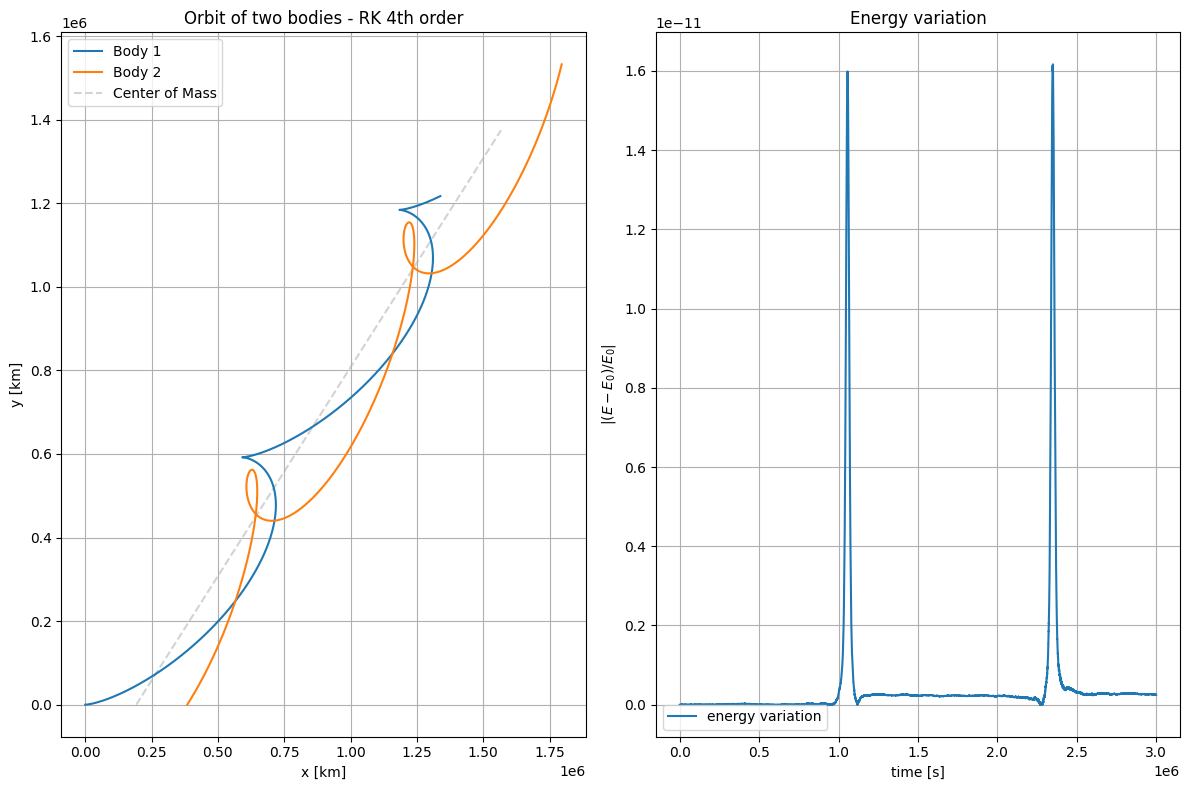

In [5]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(orbit1[:,0], orbit1[:,1], label='Body 1')
plt.plot(orbit1[:,2], orbit1[:,3], label='Body 2')
plt.plot(cm1[:,0], cm1[:,1], label='Center of Mass', linestyle='--', color='lightgrey', zorder=0)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('Orbit of two bodies - RK 4th order')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(time1, energy1, label='energy variation')
plt.xlabel('time [s]')
plt.ylabel('$|(E - E_{0})/E_{0}|$')
plt.title('Energy variation')
plt.grid()
plt.legend(loc='lower left')

plt.tight_layout()

This is a forth order integrator so we can achieve the higher precision and the globar error is $\mathcal{O}(h4)$. This method predicts very well the trajectories of the two bodies.
If we look at the energy plot, we can see two peaks, probably corresponding to the close encounter of the two bodies.

The energy error is of the order of $10^{-11}$.

Now we repeat the process but we use the integrator provided by `scipy.integrate.solve_ivp`

(8, 87)


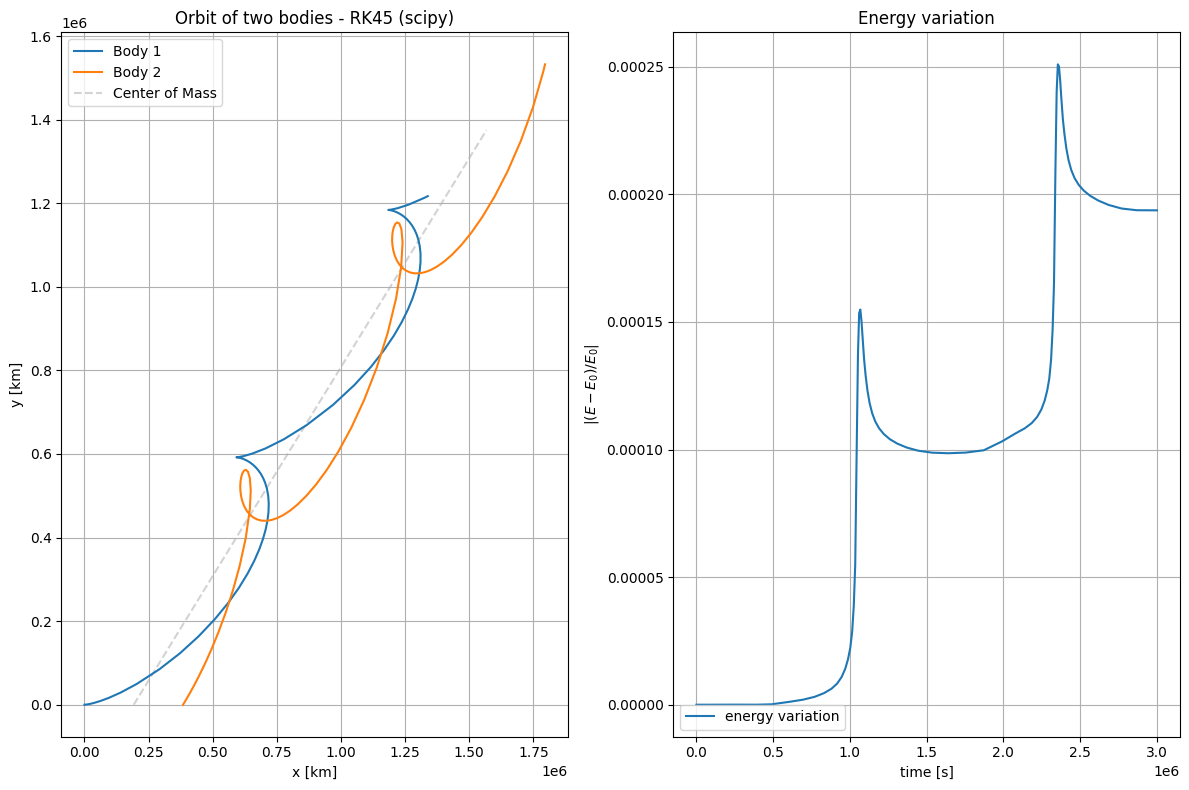

In [6]:
# ORBIT WITH SCIPY
sol = solve_ivp(fun=acceleration_two_body, t_span=[t0, tf], y0=particles, method='RK45', 
                dense_output=True, rtol=1e-6)
time2 = sol.t
print(sol.y.shape)

# calculate the position of the Center of Mass
cm2 = np.empty([sol.y.shape[1], 2], dtype=float)
for i in range(sol.y.shape[1]):
    x_cm2 = 0.5*(sol.y[0,i] + sol.y[2,i])
    y_cm2 = 0.5*(sol.y[1,i] + sol.y[3,i])
    cm2[i] = [x_cm2, y_cm2]

# calculate the energy of the system
energy2 = Energy(sol.y.T)

# plot the orbit
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(sol.y[0], sol.y[1], label='Body 1')
plt.plot(sol.y[2], sol.y[3], label='Body 2')
plt.plot(cm2[:,0], cm2[:,1], label='Center of Mass', linestyle='--', color='lightgrey', zorder=0)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('Orbit of two bodies - RK45 (scipy)')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(time2, energy2, label='energy variation')
plt.xlabel('time [s]')
plt.ylabel('$|(E - E_{0})/E_{0}|$')
plt.title('Energy variation')
plt.grid()
plt.legend(loc='lower left')

plt.tight_layout()

We can see that the plot on the left is identical to the one obtained by the *RK-4th* we wrote; the scipy integrator was left free to choose the best timestep, which in this case was 87 steps, and a relative tolerance of the order of $10^{-6}$.
The energy variation in this case is higher and less stable than in the previous case due to the fact that the timestep chosen by `scipy` was larger than the fixed one used in *RK-4th*.

The energy error is of the order of $10^{-4}$.

Let's see what happens if we reduce the relative tolerance value and keep the maximum time step size of $h=100$, the same as in the first case:

(8, 30005)


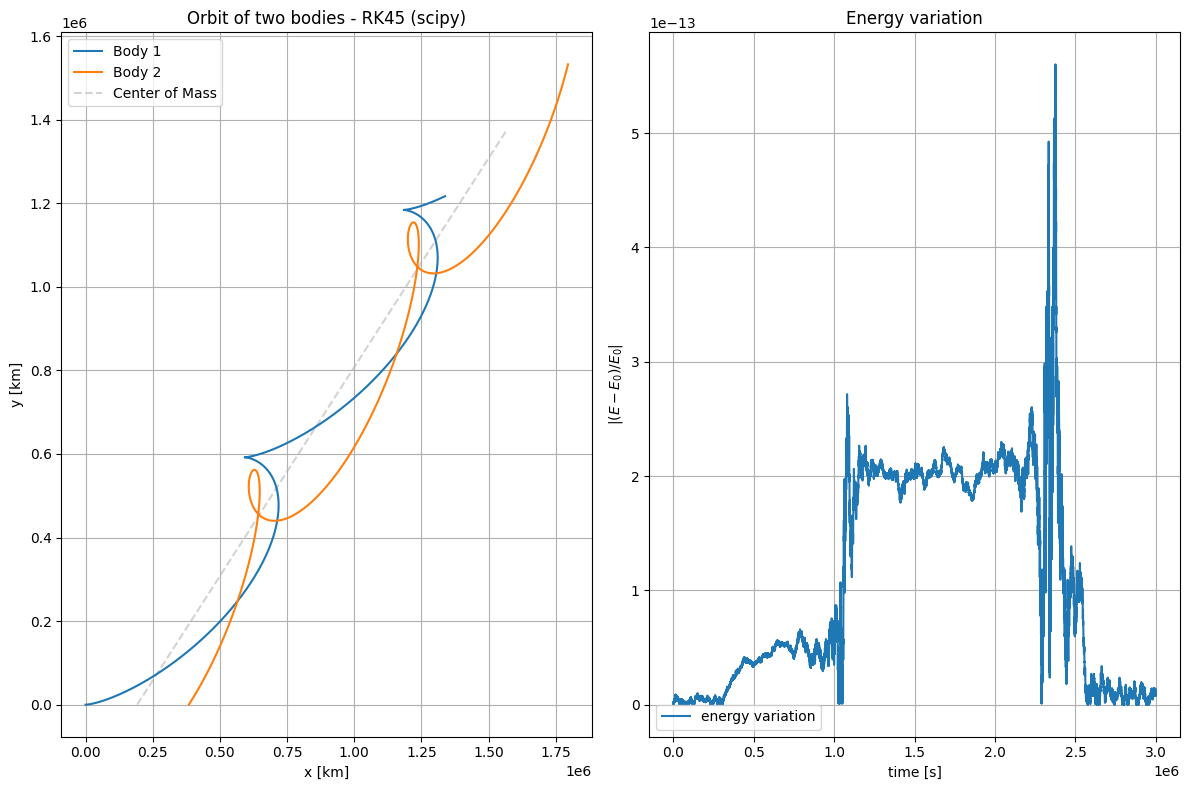

In [7]:
# ORBIT WITH SCIPY
sol = solve_ivp(fun=acceleration_two_body, t_span=[t0, tf], y0=particles, method='RK45', 
                dense_output=True, rtol=1e-12, max_step=1e2)
time2 = sol.t
print(sol.y.shape)

# calculate the position of the Center of Mass
cm2 = np.empty([sol.y.shape[1], 2], dtype=float)
for i in range(sol.y.shape[1]):
    x_cm2 = 0.5*(sol.y[0,i] + sol.y[2,i])
    y_cm2 = 0.5*(sol.y[1,i] + sol.y[3,i])
    cm2[i] = [x_cm2, y_cm2]

# calculate the energy of the system
energy2 = Energy(sol.y.T)

# plot the orbit
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(sol.y[0], sol.y[1], label='Body 1')
plt.plot(sol.y[2], sol.y[3], label='Body 2')
plt.plot(cm2[:,0], cm2[:,1], label='Center of Mass', linestyle='--', color='lightgrey', zorder=0)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('Orbit of two bodies - RK45 (scipy)')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(time2, energy2, label='energy variation')
plt.xlabel('time [s]')
plt.ylabel('$|(E - E_{0})/E_{0}|$')
plt.title('Energy variation')
plt.grid()
plt.legend(loc='lower left')

plt.tight_layout()

Here we can see a similar result for the path of the orbit, but the energy is more stable during the integration; this time we asked the integrator to keep a small relative tolerance and the "strange behavior" we can see is because the integrator tries to choose the best timestep at each step. The energy error is of the order of $10^{-13}$, so this setup is the best among the 3 we tried. A curious fact to observe is that the *RK-4th* seems to work better than the one from scipy without accuracy input parameters, maybe this could be because the scipy algorithm tries to find the best solution with the minimum computation time.

### Exercise 3
We try to solve the Pythagorean Three-Body Problem, known as **Burrau’s problem**.
First we set up the initial condition in *N-body units* so we can work with $G=1$ and less complexity. If we want to see the result in a physical system, i.e. 3 stars orbiting close to each other, we can easily convert from *N-body units* to *physical* even after the simulation by multiplying to the relative scale we want to use.

In [8]:
# initial conditions
masses = np.array([3., 4., 5.])
pos = np.array([[1., 3.], [-2., -1.], [1., -1.]])
vel = np.array([[0., 0.], [0., 0.], [0., 0.]])
#N-body units
G = 1.0   
t0 = 0.0
tf = 70.0
h0 = 0.1

For this problem, too, we choose to use an adaptive timestep, since the numerical integration must be modified accordingly when close encounters of the bodies occur.

In [9]:
def h_adaptive(r, h0):
    r12 = np.linalg.norm(r[0] - r[1])**-2.
    r23 = np.linalg.norm(r[1] - r[2])**-2.
    r31 = np.linalg.norm(r[0] - r[2])**-2.
    denominator = r12 + r23 + r31
    return h0/denominator

We also modified the *RK-4th* developed in the first exercise to be able to use an adaptive timestep.

In [10]:
def RK_4th_order_adaptive(f, x0, t0, tf, h0):
    t = np.arange(t0, tf, h0)
    n = len(t)
    x = np.zeros([n, len(x0)], dtype=float)
    x[0] = x0
    h = h_adaptive(x[0][:6].reshape(3, 2), h0)

    for i in range(n-1):
        k1 = h*f(t[i], x[i])
        k2 = h*f(t[i] + h/2, x[i] + k1/2)
        k3 = h*f(t[i] + h/2, x[i] + k2/2)
        k4 = h*f(t[i] + h, x[i] + k3)

        x[i+1] = x[i] + (k1 + 2*k2 + 2*k3 + k4)/6.0

        h = h_adaptive(x[i+1][:6].reshape(3, 2), h0)

    return t, x

and the function to calculate the energy of the system as done before

In [11]:
def Energy_3bodies(x):
    r12 = np.linalg.norm(x[:,0:2] - x[:,2:4])
    r23 = np.linalg.norm(x[:,2:4] - x[:,4:6])
    r31 = np.linalg.norm(x[:,0:2] - x[:,4:6])
    Ekin = 0.5*(masses[0]*np.sum(x[:,6:8]**2, axis=1) + masses[1]*np.sum(x[:,8:10]**2, axis=1) + masses[2]*np.sum(x[:,10:12]**2, axis=1))
    Epot = G*(masses[0]*masses[1]/r12 + masses[1]*masses[2]/r23 + masses[0]*masses[2]/r31)
    E = Ekin - Epot
    return np.abs((E - E[0])/E[0])

We then proceed by developing the function that calculates the acceleration felt for each body by the interaction with the other two:

In [12]:
def acceleration_three_body(x):
    acc = np.zeros((3,2), dtype=float)
    for i in range(3):
        for j in range(3):
            if i != j:
                r = np.linalg.norm(x[i] - x[j])
                temp = - G*masses[j]*(x[i] - x[j]) / r**3.
                acc[i,:] += temp
    return acc

Next, we write the code to generate the function to be used in the Runge-Kutta integrator

In [13]:
def f(t, x):
    r = x[0:6].reshape(3, 2)
    v = x[6:12].reshape(3, 2)
    a = acceleration_three_body(r)
    return np.array(np.concatenate((v[0], v[1], v[2], a[0], a[1], a[2]), axis=None))

**let's integrate:** First, we write the initial condition as a 1D array. We do this since our *RK-4th* integrator take as input a single array

$$
x(t) = \left(\vec{x}, \vec{\dot{x}} \right)
$$

where in this case we have all the positions of the 3 bodies and their velocities:

$$
x(t) = \left(x_1, y_2, x_2, y_2, x_3, y_3, \dot{x_1}, \dot{y_1}, \dot{x_2}, \dot{y_2}, \dot{x_3}, \dot{y_3}\right)
$$

In [14]:
x = np.concatenate((pos, vel), axis=None)

time, orbit = RK_4th_order_adaptive(f, x, t0, tf, h0)

energy = Energy_3bodies(orbit)

let's plot the final orbit

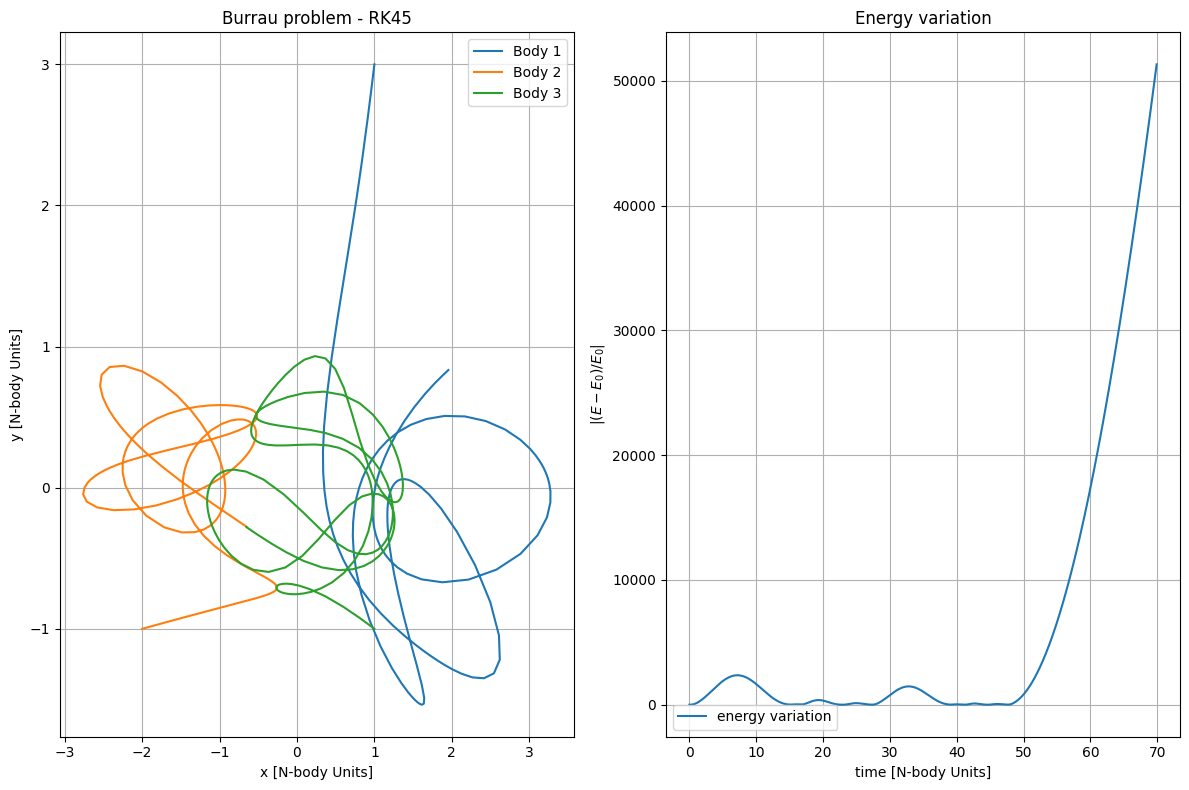

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(orbit[:,0], orbit[:,1], label='Body 1')
plt.plot(orbit[:,2], orbit[:,3], label='Body 2')
plt.plot(orbit[:,4], orbit[:,5], label='Body 3')
plt.xlabel('x [N-body Units]')
plt.ylabel('y [N-body Units]')
plt.title('Burrau problem - RK45')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(time, energy, label='energy variation')
plt.xlabel('time [N-body Units]')
plt.ylabel('$|(E - E_{0})/E_{0}|$')
plt.title('Energy variation')
plt.grid()
plt.legend(loc='lower left')

plt.tight_layout()

We can clearly see that our *RK-4th* can't properly integrate this type of problem, in fact if we look at the energy plot we see after $t=50$ the system explodes and the integrator becomes very unstable. This can be explained by the very simplicity of our integrator and to solve this kind of problems we need a higher and much more complex algorithm. 

Let's try with `scipy`:

In [16]:
solution = solve_ivp(fun=f, t_span=[t0, tf], y0=x, method='RK45', dense_output=True, rtol=1e-12, atol=1e-12)

In [17]:
energy2 = Energy_3bodies(solution.y.T)

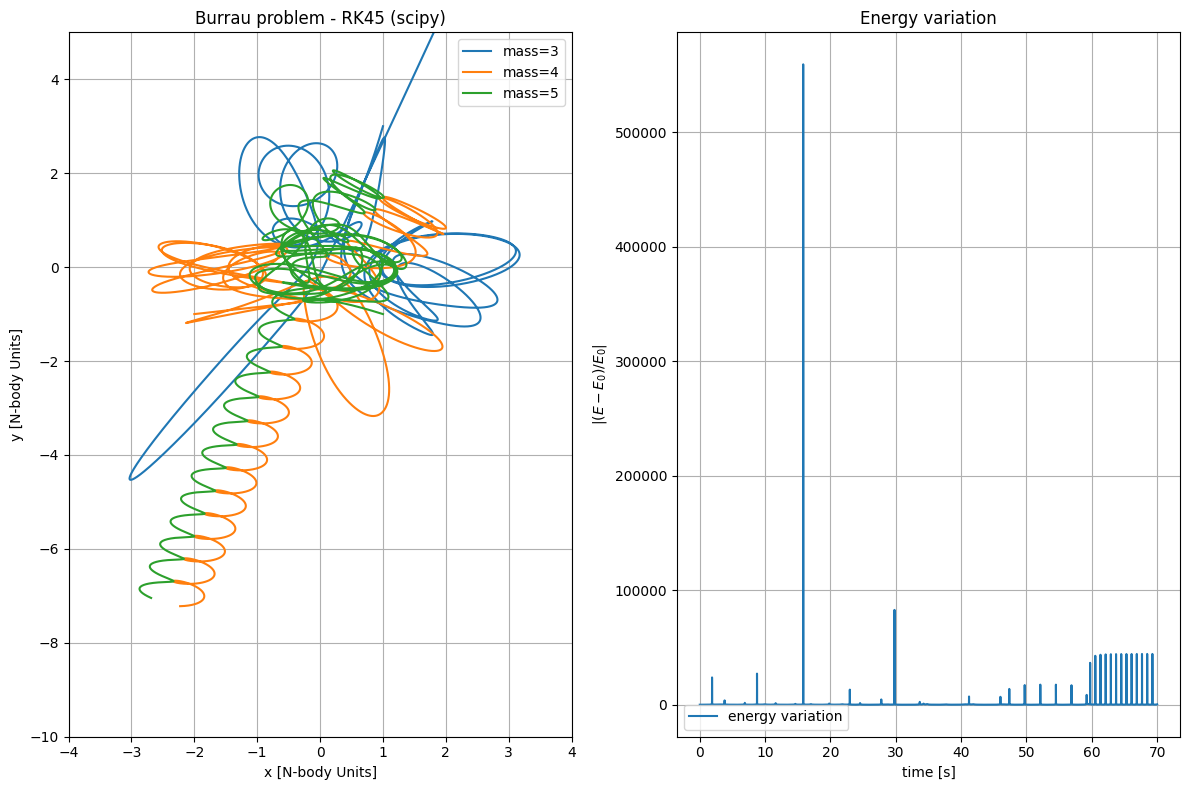

In [18]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(solution.y[0], solution.y[1], label='mass=3')
plt.plot(solution.y[2], solution.y[3], label='mass=4')
plt.plot(solution.y[4], solution.y[5], label='mass=5')
plt.xlabel('x [N-body Units]')
plt.ylabel('y [N-body Units]')
plt.title('Burrau problem - RK45 (scipy)')
plt.xlim(-4, 4)
plt.ylim(-10, 5)
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(solution.t, energy2, label='energy variation')
plt.xlabel('time [s]')
plt.ylabel('$|(E - E_{0})/E_{0}|$')
plt.title('Energy variation')
plt.grid()
plt.legend(loc='lower left')

plt.tight_layout()


With the tool given by `science.integrate` we are able to solve this problem properly. Looking on the energy plot we see some peaks corresponding to the close encounters of the bodies. We have these peaks structure because we're working in a collisionless system